In [18]:
import os
import sys
from subprocess import check_call

check_call([sys.executable, '-m' 'pip', 'install', '--user', '-U', 'pip'])

0

In [19]:
#check_call([sys.executable, '-mpip', 'install', '--user', '-U', 'alerce==1.2.0'])
#check_call([sys.executable, '-mpip', 'install', '--user', '-U', 'astro-ghost==0.2.3'])
check_call([sys.executable, '-mpip', 'install', '--user', '-U', 'astro-ghost==2.0.8'])
#check_call([sys.executable, '-mpip', 'install', '--user', '-U', 'opencv-python==4.7.0.72'])
#check_call([sys.executable, '-mpip', 'uninstall', '--user', '-U', 'astropy==5.3'])
#check_call([sys.executable, '-mpip', 'install', '--user', '-U', 'astropy==5.2.1'])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 27.5 MB/s eta 0:00:00
     ━━━

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


  Attempting uninstall: astro-ghost
    Found existing installation: astro-ghost 0.2.3
    Uninstalling astro-ghost-0.2.3:
      Successfully uninstalled astro-ghost-0.2.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
antares 2.0.6 requires numpy<1.25.0,>=1.24.0, but you have numpy 1.23.5 which is incompatible.
ssi-forest 0.1.1 requires scikit-learn<0.25,>=0.24, but you have scikit-learn 1.2.2 which is incompatible.
tensorflow-cpu 2.11.1 requires keras<2.12,>=2.11.0, but you have keras 2.12.0 which is incompatible.
tensorflow-cpu 2.11.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.23.3 which is incompatible.
tensorflow-cpu 2.11.1 requires tensorboard<2.12,>=2.11, but you have tensorboard 2.12.3 which is incompatible.
tensorflow-cpu 2.11.1 requires tensorflow-estimator<2.12,>=2.11.0, but you have tensorflow-estimator 2.12.0 which is incompatible.


0

In [1]:
# LAISS Random Forest Classifier for Transient (Supernova) Anomaly Detection
# Written by Patrick Aleo

# Import all necessary packages
import antares.devkit as dk; dk.init()

from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames

import os
import sys
import time

from alerce.core import Alerce
alerce = Alerce()

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from datetime import datetime
import tempfile

import astro_ghost
# from astro_ghost.PS1QueryFunctions import getAllPostageStamps
# from astro_ghost.TNSQueryFunctions import getTNSSpectra
# from astro_ghost.NEDQueryFunctions import getNEDSpectra
from astro_ghost.ghostHelperFunctions import getTransientHosts, getGHOST
# Throw RA/DEC into ghost with just DLR method, gentle starcut
# Sets environ var to find ghost.csv
# os.environ['GHOST_PATH'] = './host_info'
# Then don't use getGHOST(real=True, verbose=verbose)
#getGHOST(real=True,verbose=False)

from astropy import units as u
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames

import sklearn.ensemble
from sklearn.ensemble import IsolationForest

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import RandomForestClassifier

# set random seed for consistent results
import random
random.seed(0)

import warnings
warnings.filterwarnings("ignore")

def get_alerce_class(output):
    """
    Given the top 'output' probabilities from Alerce's classifiers (lc_classifier, hierarchical_rf, stamp_classifier),
    return the best class (the one displayed on the webpage at https://alerce.online/object/, typically lc_classifier). 
    If not classified, return 'Not_classified'.
    """
    top_class = None
    for item in output:
        if item['ranking'] == 1:
            if top_class is None or \
               (item['classifier_name'] == 'lc_classifier' and \
                item['classifier_version'] == 'hierarchical_rf_1.1.0') or \
               (item['classifier_name'] == 'stamp_classifier' and \
                item['classifier_version'] == 'stamp_classifier_1.0.4' and \
                top_class['classifier_version'] != 'hierarchical_rf_1.1.0') or \
               (item['classifier_name'] == 'stamp_classifier' and \
                item['classifier_version'] == 'stamp_classifier_1.0.0' and \
                top_class['classifier_version'] not in ['hierarchical_rf_1.1.0', 'stamp_classifier_1.0.4']):
                top_class = item
    return top_class['class_name'] if top_class is not None else "Not_classified"

Loading ANTARES from /data0/sw/antares-kernel/lib/python3.9/site-packages/antares/__init__.py

        _    _   _ _____  _    ____  _____ ____
       / \  | \ | |_   _|/ \  |  _ \| ____/ ___|
      / _ \ |  \| | | | / _ \ | |_| |  _| \___ \\
     / ___ \| |\  | | |/ ___ \|  _ /| |___ ___| |
    /_/   \_\_| \_| |_/_/   \_\_| \_\_____|____/   v2.4.2
    
2023-06-30 08:46:17,989 - WARNING MainThread settings.py:setup_prometheus:124 - Prometheus failed to start with [Errno 98] Address already in use


Jaeger tracer already initialized, skipping


2023-06-30 08:46:18,146 - WARNING MainThread settings.py:setup_prometheus:124 - Prometheus failed to start with [Errno 98] Address already in use
Testing loading a random Locus with `dk.get_locus()`...
2023-06-30 08:46:21,145 - INFO MainThread settings.py:cassandra_session_factory:84 - Establishing connection to Cassandra
2023-06-30 08:46:22,309 - INFO MainThread settings.py:cassandra_session_factory:88 - Connection to Cassandra established
2023-06-30 08:46:22,311 - INFO MainThread settings.py:cassandra_session_factory:84 - Establishing connection to Cassandra
2023-06-30 08:46:23,461 - INFO MainThread settings.py:cassandra_session_factory:88 - Connection to Cassandra established
2023-06-30 08:46:23,463 - INFO MainThread settings.py:cassandra_session_factory:84 - Establishing connection to Cassandra
2023-06-30 08:46:24,715 - INFO MainThread settings.py:cassandra_session_factory:88 - Connection to Cassandra established

ANTARES v2.4.2 DevKit is ready!
Website: https://antares.noirlab.edu

In [31]:
%time
class LAISS_RFC_AD_filter(dk.Filter):
    NAME = 'LAISS_RFC_AD_filter'
    ERROR_SLACK_CHANNEL = 'U0135TMN9UK'  # Patrick Aleo Slack member ID
    REQUIRES_FILES = [
    #    './paleo2_106IFmodel_472727objs_nest=1000_cont=0.001_transf.pkl', #106 feature Isolation Forest model
    #    './antares_norm.py' #py file for transforming ZTF alert feature values
        './data/database/',
    ]
    REQUIRED_LOCUS_PROPERTIES = [
        'ztf_object_id',
    ]
    REQUIRED_ALERT_PROPERTIES = [
    ]
    INPUT_TAGS = [
        'lc_feature_extractor'
    ]
    OUTPUT_LOCUS_PROPERTIES = [
          {
          'name': 'LAISS_RFC_anomaly_score',
          'type': 'float',
          'description': 'Calculated anomaly score. From RFC model, objects are tagged as anomalous if "Other" (anomaly) classification is >0.5 at any point during light curve evolution. If none calculated, set to TBD',
          },
    ]
    OUTPUT_ALERT_PROPERTIES = [
    ]
    OUTPUT_TAGS = [
        {
          'name': 'LAISS_RFC_AD_filter', 
          'description': 'The Light Curve AI Similarity Search (LAISS; Aleo et al in prep) random forest classifier anomaly detection filter aims to tag rare, exotic, and unusual transients (supernovae). It is an random forest classifier algorithm trained on upsampled (balanced classes) spectroscopic SNe using extracted light curve and host galaxy features.',
        },
    ]

    
    def setup(self):
        """
    #    ANTARES will call this function once at the beginning of each night
    #    when filters are loaded.
    #    """
        # Sets environ var to find ghost.csv
        #os.environ['GHOST_PATH'] = './data'
        #print(os.environ['GHOST_PATH'])
        # Then don't use getGHOST(real=True, verbose=verbose)
        #getGHOST(real=False,verbose=False)
        #print(os.environ['GHOST_PATH'])
        
        # Sets environ var to find ghost.csv
        os.environ['GHOST_PATH'] = './host_info'
        # Then don't use getGHOST(real=True, verbose=verbose)
        getGHOST(real=True,verbose=True)
        
        # From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
        # R and g bands
        self.feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         #'feature_linear_trend_magn_r', # cadence removal
                         #'feature_linear_trend_sigma_magn_r',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         #'feature_period_s_to_n_0_magn_r', # cadence removal
                         #'feature_period_1_magn_r', 
                         #'feature_period_s_to_n_1_magn_r', # cadence removal
                         #'feature_period_2_magn_r', 
                         #'feature_period_s_to_n_2_magn_r', # cadence removal
                         #'feature_period_3_magn_r', 
                         #'feature_period_s_to_n_3_magn_r', # cadence removal
                         #'feature_period_4_magn_r', 
                         #'feature_period_s_to_n_4_magn_r', # cadence removal
                         #'feature_periodogram_amplitude_magn_r',
                         #'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                         #'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         #'feature_linear_trend_magn_g', # cadence removal
                         #'feature_linear_trend_sigma_magn_g',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         #'feature_period_s_to_n_0_magn_g', # cadence removal
                         #'feature_period_1_magn_g', 
                         #'feature_period_s_to_n_1_magn_g', # cadence removal
                         #'feature_period_2_magn_g', 
                         #'feature_period_s_to_n_2_magn_g', # cadence removal
                         #'feature_period_3_magn_g', 
                         #'feature_period_s_to_n_3_magn_g', # cadence removal
                         #'feature_period_4_magn_g', 
                         #'feature_period_s_to_n_4_magn_g', # cadence removal
                         #'feature_periodogram_amplitude_magn_g',
                         #'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                         #'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g']   
        
        self.feature_names_hostgal = [
            #  'Unnamed: 0',
            #  'level_0',
            #  'index',
            #  'objName',
            #  'objAltName1',
            #  'objAltName2',
            #  'objAltName3',
            #  'objID',
            #  'uniquePspsOBid',
            #  'ippObjID',
            #  'surveyID',
            #  'htmID',
            #  'zoneID',
            #  'tessID',
            #  'projectionID',
            #  'skyCellID',
            #  'randomID',
            #  'batchID',
            #  'dvoRegionID',
            #  'processingVersion',
            #  'objInfoFlag',
            #  'qualityFlag',
            #  'raStack',
            #  'decStack',
            #  'raStackErr',
            #  'decStackErr',
            #  'raMean',
            #  'decMean',
            #  'raMeanErr',
            #  'decMeanErr',
            #  'epochMean',
            #  'posMeanChisq',
            #  'cx',
            #  'cy',
            #  'cz',
            #  'lambda',
            #  'beta',
            #  'l',
            #  'b',
            #  'nStackObjectRows',
            #  'nStackDetections',
            #  'nDetections',
            #  'ng',
            #  'nr',
            #  'ni',
            #  'nz',
            #  'ny',
            #  'uniquePspsSTid',
            #  'primaryDetection',
            #  'bestDetection',
            #  'gippDetectID',
            #  'gstackDetectID',
            #  'gstackImageID',
            #  'gra',
            #  'gdec',
            #  'graErr',
            #  'gdecErr',
            #  'gEpoch',
            #  'gPSFMag',
            #  'gPSFMagErr',
            #  'gApMag',
            #  'gApMagErr',
            #  'gKronMag',
            #  'gKronMagErr',
            #  'ginfoFlag',
            #  'ginfoFlag2',
            #  'ginfoFlag3',
            #  'gnFrames',
            #  'gxPos',
            #  'gyPos',
            #  'gxPosErr',
            #  'gyPosErr',
            #  'gpsfMajorFWHM',
            #  'gpsfMinorFWHM',
            #  'gpsfTheta',
            #  'gpsfCore',
            #  'gpsfLikelihood',
            #  'gpsfQf',
            #  'gpsfQfPerfect',
            #  'gpsfChiSq',
             'gmomentXX',
             'gmomentXY',
             'gmomentYY',
             'gmomentR1',
             'gmomentRH',
             'gPSFFlux',
            #  'gPSFFluxErr',
             'gApFlux',
            #  'gApFluxErr',
            #  'gApFillFac',
            #  'gApRadius',
             'gKronFlux',
            #  'gKronFluxErr',
             'gKronRad',
            #  'gexpTime',
             'gExtNSigma',
            #  'gsky',
            #  'gskyErr',
            #  'gzp',
            #  'gPlateScale',
            #  'rippDetectID',
            #  'rstackDetectID',
            #  'rstackImageID',
            #  'rra',
            #  'rdec',
            #  'rraErr',
            #  'rdecErr',
            #  'rEpoch',
            # 'rPSFMag',
            #  'rPSFMagErr',
            # 'rApMag',
            #  'rApMagErr',
            # 'rKronMag',
            #  'rKronMagErr',
            #  'rinfoFlag',
            #  'rinfoFlag2',
            #  'rinfoFlag3',
            #  'rnFrames',
            #  'rxPos',
            #  'ryPos',
            #  'rxPosErr',
            #  'ryPosErr',
            #  'rpsfMajorFWHM',
            #  'rpsfMinorFWHM',
            #  'rpsfTheta',
            #  'rpsfCore',
            #  'rpsfLikelihood',
            #  'rpsfQf',
            #  'rpsfQfPerfect',
            #  'rpsfChiSq',
             'rmomentXX',
             'rmomentXY',
             'rmomentYY',
             'rmomentR1',
             'rmomentRH',
            'rPSFFlux',
            #  'rPSFFluxErr',
            'rApFlux',
            #  'rApFluxErr',
            #  'rApFillFac',
            # 'rApRadius',
            'rKronFlux',
            #  'rKronFluxErr',
            'rKronRad',
            #  'rexpTime',
             'rExtNSigma',
            #  'rsky',
            #  'rskyErr',
            #  'rzp',
            #  'rPlateScale',
            #  'iippDetectID',
            #  'istackDetectID',
            #  'istackImageID',
            #  'ira',
            #  'idec',
            #  'iraErr',
            #  'idecErr',
            #  'iEpoch',
            #  'iPSFMag',
            #  'iPSFMagErr',
            #  'iApMag',
            #  'iApMagErr',
            #  'iKronMag',
            #  'iKronMagErr',
            #  'iinfoFlag',
            #  'iinfoFlag2',
            #  'iinfoFlag3',
            #  'inFrames',
            #  'ixPos',
            #  'iyPos',
            #  'ixPosErr',
            #  'iyPosErr',
            #  'ipsfMajorFWHM',
            #  'ipsfMinorFWHM',
            #  'ipsfTheta',
            #  'ipsfCore',
            #  'ipsfLikelihood',
            #  'ipsfQf',
            #  'ipsfQfPerfect',
            #  'ipsfChiSq',
              'imomentXX',
             'imomentXY',
             'imomentYY',
             'imomentR1',
             'imomentRH',
             'iPSFFlux',
            #  'iPSFFluxErr',
             'iApFlux',
            #  'iApFluxErr',
            #  'iApFillFac',
            #  'iApRadius',
             'iKronFlux',
            #  'iKronFluxErr',
             'iKronRad',
            #  'iexpTime',
              'iExtNSigma',
            #  'isky',
            #  'iskyErr',
            #  'izp',
            #  'iPlateScale',
            #  'zippDetectID',
            #  'zstackDetectID',
            #  'zstackImageID',
            #  'zra',
            #  'zdec',
            #  'zraErr',
            #  'zdecErr',
            #  'zEpoch',
            #  'zPSFMag',
            #  'zPSFMagErr',
            #  'zApMag',
            #  'zApMagErr',
            #  'zKronMag',
            #  'zKronMagErr',
            #  'zinfoFlag',
            #  'zinfoFlag2',
            #  'zinfoFlag3',
            #  'znFrames',
            #  'zxPos',
            #  'zyPos',
            #  'zxPosErr',
            #  'zyPosErr',
            #  'zpsfMajorFWHM',
            #  'zpsfMinorFWHM',
            #  'zpsfTheta',
            #  'zpsfCore',
            #  'zpsfLikelihood',
            #  'zpsfQf',
            #  'zpsfQfPerfect',
            #  'zpsfChiSq',
              'zmomentXX',
             'zmomentXY',
             'zmomentYY',
             'zmomentR1',
             'zmomentRH',
             'zPSFFlux',
            # #  'zPSFFluxErr',
             'zApFlux',
            # #  'zApFluxErr',
            # #  'zApFillFac',
            # #  'zApRadius',
             'zKronFlux',
            # #  'zKronFluxErr',
             'zKronRad',
            # #  'zexpTime',
              'zExtNSigma',
            #  'zsky',
            #  'zskyErr',
            #  'zzp',
            #  'zPlateScale',
            #  'yippDetectID',
            #  'ystackDetectID',
            #  'ystackImageID',
            #  'yra',
            #  'ydec',
            #  'yraErr',
            #  'ydecErr',
            #  'yEpoch',
            #  'yPSFMag',
            #  'yPSFMagErr',
            #  'yApMag',
            #  'yApMagErr',
            #  'yKronMag',
            #  'yKronMagErr',
            #  'yinfoFlag',
            #  'yinfoFlag2',
            #  'yinfoFlag3',
            #  'ynFrames',
            #  'yxPos',
            #  'yyPos',
            #  'yxPosErr',
            #  'yyPosErr',
            #  'ypsfMajorFWHM',
            #  'ypsfMinorFWHM',
            #  'ypsfTheta',
            #  'ypsfCore',
            #  'ypsfLikelihood',
            #  'ypsfQf',
            #  'ypsfQfPerfect',
            #  'ypsfChiSq',
              'ymomentXX',
              'ymomentXY',
              'ymomentYY',
              'ymomentR1',
              'ymomentRH',
              'yPSFFlux',
            # #   'yPSFFluxErr',
              'yApFlux',
            # #   'yApFluxErr',
            # #   'yApFillFac',
            # #  'yApRadius',
             'yKronFlux',
            # #  'yKronFluxErr',
             'yKronRad',
            # #  'yexpTime',
              'yExtNSigma',
            #  'ysky',
            #  'yskyErr',
            #  'yzp',
            #  'yPlateScale',
            #  'distance',
            #  'SkyMapper_StarClass',
            #  'gelong',
            #  'g_a',
            #  'g_b',
            #  'g_pa',
            #  'relong',
            #  'r_a',
            #  'r_b',
            #  'r_pa',
            #  'ielong',
            #  'i_a',
            #  'i_b',
            #  'i_pa',
            #  'zelong',
            #  'z_a',
            #  'z_b',
            #  'z_pa',
               'i-z', # try throwing in
            #    'g-r',
            #    'r-i',
            #    'g-i',
            #    'z-y',
            #   'g-rErr',
            #   'r-iErr',
            #   'i-zErr',
            #   'z-yErr',
             'gApMag_gKronMag',
             'rApMag_rKronMag',
             'iApMag_iKronMag',
             'zApMag_zKronMag',
             'yApMag_yKronMag',
             '7DCD', 
            #  'NED_name',
            #  'NED_type',
            #  'NED_vel',
            #  'NED_redshift',
            #  'NED_mag',
            #  'class',
               'dist/DLR',
            #   'dist',
            #  'TransientClass',
            #  'TransientRA',
            #  'TransientDEC'
               ]
        
#         # Load 106 feature IF model at beginning of the night and store it. 
#         #self.IF_model = self.files['./paleo2_106IFmodel_472727objs_nest=1000_cont=0.001_transf.pkl']
#         with open('./paleo2_106IFmodel_472727objs_nest=1000_cont=0.001_transf.pkl', 'rb') as f: #not imported right way
#             self.clf = pickle.load(f)
        
#         # Return the model to use in run(self, locus)
#         return self.clf


        n_estimators=100 
        max_depth=35 
        random_state=11
        max_features=35
        with open(f'./model/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced.pkl', 'rb') as f:
            self.clf = pickle.load(f)

        return self

    def run(self, locus):
        """
        Send alerts to stream 'LAISS_RFC_AD_filter' if alert was received from 'lc_feature_extractor' filter,
        assigned an anomaly score from trained RFC model (requires both R, g bands),
        and passes strict masking requirement to filter out unwanted periodic objects to maximise anomalous,
        transient events. 
        """
        
        # Required: if the loci has passed through the 'lc_feature_extractor' filter
        if 'lc_feature_extractor' in locus.tags:
            
            # from locus info, get ra,dec and cut on objs in galactic plane
            loci_coord = SkyCoord(locus.ra*u.deg, 
                                     locus.dec*u.deg, 
                                     frame="icrs", 
                                     unit='deg')
            loci_galcoord = loci_coord.galactic
            # cut on anything in galactic plane
            if np.abs(loci_galcoord.b.degree) < 15:
                print(f"In galactic plane at b={loci_galcoord.b.degree}. Don't use. Skip!")
                return

            # Make dictionary. Make keys ZTF IDs
            locus_dict = {}
            ztf_id = locus.properties['ztf_object_id']
            # Get extracted LC feature values from ANTARES db
            try:
                locus_dict[ztf_id] = [locus.properties[feature] for feature in self.feature_names_r_g]
            except:
                print(f"Only one passband of LC feature data for {ztf_id}. Skip!")
                return
            loci_df = pd.DataFrame.from_dict(locus_dict).T
            loci_df.columns = self.feature_names_r_g

            # Drop row if any feature values are nan
            loci_df = loci_df[~loci_df[self.feature_names_r_g].isnull().any(axis=1)]
            loci_df['TransientName'] = ztf_id
            loci_df = loci_df.set_index('TransientName')
            
            if len(loci_df) < 1:
                print("Had NaN features. Must drop. Skip!")
                return
            
            #print(loci_df)
            
            # Query for Alerce best classifier result (i.e. what is displayed on the object page)
            try:
                probabilities = alerce.query_probabilities(ztf_id)
                alerce_cls = get_alerce_class(probabilities)
                print("alerce_cls", alerce_cls)
            except:
                print("error getting best alerce classifier result. Skip!")
                alerce_cls = 'Error'
                return
            
            # If Alerce's classifier does not say SN, don't consider this object
            # Cuts many stars, AGN, etc. that are outside of galactic plane
            if not alerce_cls.startswith('S'): 
                # Alerce LC classifier possible classes: 
                #   ['AGN', 'Blazar', 'CEP', 'CV/Nova', 'DSCT', 'E', 'Error', 'LPV',
                #  'Not_classified', 'Periodic-Other', 'QSO', 'RRL', 'SLSN', 'SN',
                #   'SNII', 'SNIa', 'SNIbc', 'VS', 'YSO', 'asteroid', 'bogus']
                
                # Alerce Stamp classifier possible classes:
                #   ['AGN', 'asteroid', 'bogus, 'SN', 'VS']
                print(f"Alerce class={alerce_cls} is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc'). Skip!")
                return
            
            # Passed first round of cuts.
            # Now, get GHOST host association for host galaxy features.
            with tempfile.TemporaryDirectory() as tmp:
                
                #TODO: in future, save GHOST events. And then if obj has GHOST host features,
                # then don't run again b/c host won't change...
                
                try: 
                    # in new version, snName -> transientName
                    hosts_df = getTransientHosts(transientName=[ztf_id], snCoord=[loci_coord], verbose=0, starcut='gentle', 
                                              ascentMatch=False, savepath=tmp, redo_search=True)
                    print(f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={hosts_df.raMean.values[0]}+{hosts_df.decMean.values[0]}&filter=color')
                    hosts_df = hosts_df.set_index('TransientName')
                    #print(list(hosts_df.columns))
                    #print(set(list(self.feature_names_hostgal)) - set(list(hosts_df.columns)))
                    hosts_df = hosts_df[self.feature_names_hostgal]
                    #print(hosts_df)
                    
                except:
                    print("GHOST host association fails. Skip!")
                    return
            # Got a GHOST host association. 
            # Match PS1 objIDs from GHOST into PS1 PSC, 
            # and cut to only retain extended sources (galaxies) at location of the host (not transient).
            
            # TODO, but ps1-psc is ~18GBs, so make sure it's ok w/ ANTARES before downloading
            # For now, move on...    
                
            # Combine LC and host galaxy features into one dataframe.
            # We will use this as input into RFC!
            lc_and_hosts_df = pd.concat([loci_df, hosts_df], axis=1)
            #lc_and_hosts_df['dist/DLR'] = np.nan # To test NaN features        
            lc_and_hosts_df = lc_and_hosts_df[~lc_and_hosts_df.isnull().any(axis=1)]

            if len(lc_and_hosts_df) < 1:
                # if any features are nan, we can't use as input
                print("Some features are NaN. Skip!")
                return

            
            #print(lc_and_hosts_df) 
            anom_thresh = 50 # 50% thresh for 'Anomaly' or 'Other' class
            try:
                pred_prob_anom = 100 * self.clf.predict_proba(lc_and_hosts_df)
                num_anom_epochs = len(np.where(pred_prob_anom[:, 1]>=anom_thresh)[0])
                #print("pred_prob_anom", pred_prob_anom)
                #print("Len", len(pred_prob_anom))
            except:
                print("Something wrong when fitting the model. Skip!")
                return

            if round(pred_prob_anom[:, 1][0], 2) < anom_thresh:
                print(f"Not anomalous according to RFC model (anom score={round(pred_prob_anom[:, 1][0], 2)}%). Skip!")
                return
            
            else: 
                # Assign locus property saving anomaly score
                locus.properties['LAISS_RFC_anomaly_score'] = round(pred_prob_anom[:, 1][0], 2)
                print(f"Anomalous! LAISS_RFC_anomaly_score={round(pred_prob_anom[:, 1][0], 2)}%")

                # Plot since passed anomaly threshold
                df_ref = locus.timeseries.to_pandas()

                df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
                df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

                mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
                mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

                fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5,7))
                ax1.invert_yaxis()
                ax1.errorbar(x=df_ref_r.ant_mjd, y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
                            label=f'REF: {ztf_id}')
                ax1.errorbar(x=df_ref_g.ant_mjd, y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
                if df_ref_g.ant_mjd[-1] < df_ref_r.ant_mjd[-1]:
                    ax1.axvline(x=df_ref_r.ant_mjd[-1], c='#ff7f0e')
                else: ax1.axvline(x=df_ref_g.ant_mjd[-1], c='#ff7f0e')
                #ax1.set_xlim(min(df_ref_r.ant_mjd), max(df_ref_r.ant_mjd))

                print(f'https://alerce.online/object/{ztf_id}')
                ax2.scatter(df_ref_r.ant_mjd[-1], pred_prob_anom[:, 0], label='p(Normal)')
                ax2.scatter(df_ref_r.ant_mjd[-1], pred_prob_anom[:, 1], label='p(Other)')
                ax2.axhline(y=anom_thresh, c='k', ls='--')



                ax2.set_ylim(0,100)
                plt.xlabel('ant_mjd')
                plt.ylabel('Probability (%)')
                plt.legend()
                plt.show()


                # TAG Locus if passed anomaly threshold!
                locus.tag('LAISS_RFC_AD_filter')
                    

        else:
            locus.properties['anomaly_type'] = 'TBD'
            pass

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 21 µs


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
alerce_cls SLSN
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=217.90780727+6.17865014&filter=color
Anomalous! LAISS_RFC_anomaly_score=70.0%


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished


https://alerce.online/object/ZTF21aafmkjk


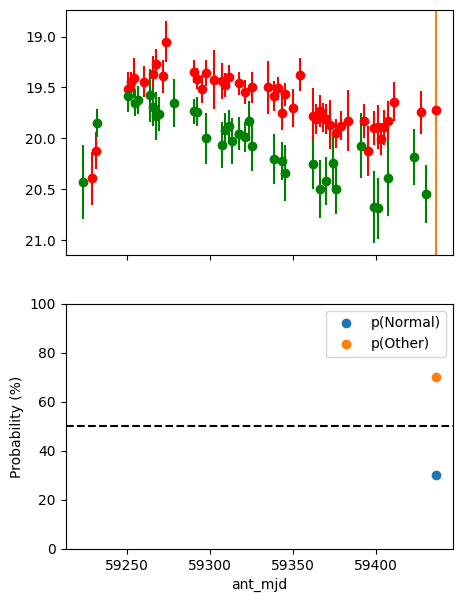

{'locus_id': 'ANT2021cydny', 'locus_data': FilterContext(locus_id="ANT2021cydny"), 't': 14.476532134999957, 'new_locus_properties': {'LAISS_RFC_anomaly_score': 70.0}, 'new_alert_properties': {}, 'new_tags': {'LAISS_RFC_AD_filter'}, 'raised_halt': False}


In [32]:
#report = dk.run_filter(LAISS_RFC_AD_filter, locus='ANT2020aes3osq') # SLSN
#report = dk.run_filter(LAISS_RFC_AD_filter, locus='ANT2022a6ub4') # Faint SN 
#report = dk.run_filter(LAISS_RFC_AD_filter, locus='ANT2022azfzi') # SN 
#report = dk.run_filter(LAISS_RFC_AD_filter, locus='ANT20235wlqblnn7mgp') # Bright Ia
#report = dk.run_filter(LAISS_RFC_AD_filter, locus='ANT2020ae6pkcy') # Ic that's anom - ghost features don't return the right ones from SIMBAD hierarchical stuff
#report = dk.run_filter(LAISS_RFC_AD_filter, locus='ANT20202oqw4') # Ic that's anom - is GLADE but doesn't return right PS1 features
report = dk.run_filter(LAISS_RFC_AD_filter, locus='ANT2021cydny') # IIn that's anom
#report = dk.run_filter(LAISS_RFC_AD_filter, locus='ANT2018dl52m') # Star - galactic plane
#report = dk.run_filter(LAISS_RFC_AD_filter, locus='ANT2019nogmu') # Star - not in galactic plane

#report = dk.run_filter(LAISS_RFC_AD_filter)
print(report)

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
In galactic plane at b=12.453769591179459. Don't use. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
2023-06-30 10:07:00,661 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object_id=767849552)
alerce_cls Blazar
Alerce class=Blazar is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc'). Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
alerce_cls SNIbc
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=263.34870468+51.16505455&filter=color
Not anomalous according to RFC model (anom score=37.0%). Skip!


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished
Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
alerce_cls QSO
Alerce class=QSO is not SN ('SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc'). Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
alerce_cls SNIa
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=262.79435469+29.62719334&filter=color
Not anomalous according to RFC model (anom score=29.0%). Skip!


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished
Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
alerce_cls SLSN
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=326.50542262+30.84118273&filter=color
Not anomalous according to RFC model (anom score=43.99%). Skip!


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished
Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
alerce_cls SNIa
Found 1 hosts in GLADE! See gladeDLR.txt for details.
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=158.883636+37.649456&filter=color
GHOST host association fails. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
alerce_cls SLSN
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Found matches for 0.0% of events.
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=324.41048667+16.33348846&filter=color
Anomalous! LAISS_RFC_anomaly_score=69.0%


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished


https://alerce.online/object/ZTF22abfdzrv


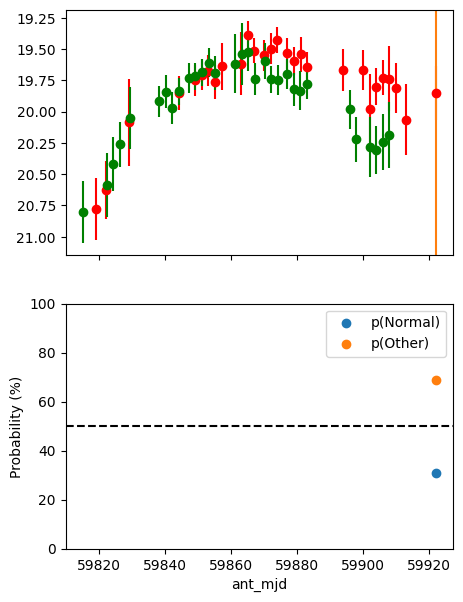

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
alerce_cls SLSN
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Found matches for 0.0% of events.
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Found matches for 0.0% of events.
GHOST host association fails. Skip!


Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
alerce_cls SLSN
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=356.4045722+29.63976879&filter=color
Some features are NaN. Skip!
CPU times: user 1min 53s, sys: 2.93 s, total: 1min 56s
Wall time: 2min 34s


In [33]:
%%time
locus_l = ['ANT2023qm4kk6rumag1','ANT2023aq21pb8wwx9h','ANT2023lwkizc214v3c','ANT2023qqx12rcysbiu','ANT2023hprgweyn8fyx',
           'ANT2022y495anna579h','ANT20223vl41wbwvauh','ANT2022kru0dw8kijis','ANT202297goejtz3so3','ANT20225fx7wc8r3nvv']
for loc in locus_l:
    report = dk.run_filter(LAISS_RFC_AD_filter, locus=loc)

In [34]:
%%time

# run LAISS_RFC_AD_filter on n random Locus Ids
report = dk.run_many(LAISS_RFC_AD_filter, n=500)

print(report)

Span has already been finished; will not be reported again.


GHOST database already exists in the install path!
Locus ANT202380vfrkjkrd8x skipped because it doesn't satisfy the filter constraints: a property is not in the Locus's input_properties or alert properties or an input_tag is not in the Locus's input_tags.
Locus ANT20235r6rk8yd4bn3 skipped because it doesn't satisfy the filter constraints: a property is not in the Locus's input_properties or alert properties or an input_tag is not in the Locus's input_tags.
Locus ANT2023dwzdycjcc0ae skipped because it doesn't satisfy the filter constraints: a property is not in the Locus's input_properties or alert properties or an input_tag is not in the Locus's input_tags.
Locus ANT2023wwpo4413avzv skipped because it doesn't satisfy the filter constraints: a property is not in the Locus's input_properties or alert properties or an input_tag is not in the Locus's input_tags.
2023-06-30 10:11:10,210 - WARNING MainThread cassandra.py:list_by_location:1187 - Catalog object not found (catalog_id=19, object

In [76]:
astro_ghost.__version__

'2.0.8'

In [12]:
import astropy
astropy.__version__

'5.2.1'